# 🌍 Notebook 3 — Visualization & Interpretation

### Overview
This notebook provides the **final analytical and visualization stage** of the GDP 2005–2025 project.  
Here we combine cleaned and prepared data from previous notebooks to create interactive dashboards,  
analyze trends, and summarize global insights.

**Goals:**
- Transform prepared data into interactive, interpretable visualizations.  
- Explore GDP trends, growth patterns, and regional differences.  
- Perform regression-based trend analysis.  
- Present final findings and analytical conclusions.

---

### 📘 Table of Contents

1. [Setup & Data Load](#setup--data-load)  
2. [Key Research Questions (KRQ)](#key-research-questions-krq)  
3. [Data Preparation for Visualization](#data-preparation-for-visualization)  
4. [Regression Analysis (GDP ~ Year)](#regression-analysis-gdp--year)  
5. [GDP Dashboard](#gdp-dashboard)  
6. [Findings & Conclusions](#findings--conclusions)


<a id="setup--data-load"></a>
## Setup & Data Load


In this first step, we import all required Python libraries and load the prepared dataset `daten/GDP_cleaned_long.csv`, which contains GDP values by country and year.

**Goal:**
- Initialize the environment for visualization and modeling.  
- Verify that the dataset is correctly formatted (Country | Year | GDP).  
- Inspect data types, missing values, and basic descriptive statistics.

**Expected Output:**
- Dataset successfully loaded as `Dataset`.  
- Summary of rows, columns, data types, and sample records printed below.  


In [13]:
# Step 1 – Setup & Data Load

# Imports
import pandas as pd
import numpy as np
from pathlib import Path

# Visual libs (used later in this notebook)
import plotly.express as px
import plotly.graph_objects as go

# Paths
DATA_PATH = Path("daten") / "GDP_cleaned_long.csv"

# Load
Dataset = pd.read_csv(DATA_PATH)

# Basic normalization (ensure expected schema)
expected_cols = {"Country", "Year", "GDP"}
missing_cols = expected_cols - set(Dataset.columns)
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}. Found: {list(Dataset.columns)}")

# Dtypes
Dataset["Year"] = pd.to_numeric(Dataset["Year"], errors="coerce").astype("Int64")
Dataset["GDP"]  = pd.to_numeric(Dataset["GDP"], errors="coerce")

# Quick sanity checks
n_rows, n_cols = Dataset.shape
n_countries = Dataset["Country"].nunique(dropna=True)
years_min, years_max = Dataset["Year"].min(), Dataset["Year"].max()
na_counts = Dataset.isna().sum()
dup_count = Dataset.duplicated(subset=["Country", "Year"]).sum()

print("=== Dataset Loaded ===")
print(f"Path: {DATA_PATH}")
print(f"Shape: {n_rows} rows × {n_cols} cols")
print(f"Countries: {n_countries}")
print(f"Years range: {years_min}–{years_max}")
print(f"Duplicates (by Country+Year): {dup_count}")
print("\nMissing values per column:")
print(na_counts.to_string())

print("\nDtypes:")
print(Dataset.dtypes.to_string())

print("\nSample records:")
display(Dataset.head(10))

# Optional: ensure canonical ordering for later steps
Dataset = Dataset.sort_values(["Country", "Year"]).reset_index(drop=True)


=== Dataset Loaded ===
Path: daten\GDP_cleaned_long.csv
Shape: 4116 rows × 3 cols
Countries: 196
Years range: 2005–2025
Duplicates (by Country+Year): 0

Missing values per column:
Country     0
Year        0
GDP        38

Dtypes:
Country     object
Year         Int64
GDP        float64

Sample records:


,Country,Year,GDP
0,Afghanistan,2005,6167.0
1,Albania,2005,8148.0
2,Algeria,2005,107047.0
3,Andorra,2005,3158.0
4,Angola,2005,41397.0
5,Antigua and Barbuda,2005,1144.0
6,Argentina,2005,199273.0
7,Armenia,2005,4900.0
8,Aruba,2005,2360.0
9,Australia,2005,736505.0


<a id="key-research-questions-krq"></a>
## Key Research Questions (KRQ)


Before creating visualizations, we define the analytical focus of this notebook.

### Main Questions
1. **Which countries show the strongest GDP growth from 2005 to 2025?**  
   → Identify top and bottom performers based on growth rates and trend slopes.

2. **How does GDP differ across world regions and income groups?**  
   → Compare aggregated regional totals and observe structural differences.

3. **What global trends can be seen in GDP development over time?**  
   → Examine long-term trajectories for leading economies and emerging markets.

4. **How consistent are growth patterns across the dataset?**  
   → Check GDP volatility and inequality within and between regions.

### Expected Outcome
Each question will be answered visually in the following sections:
- **Line chart:** Trends over time for selected countries.  
- **Stacked bar chart:** Regional GDP totals per year.  
- **Box plot:** Distribution of GDP by region.  

Together, these plots will form one interactive figure and later feed into the final Plotly Dashboard.


<a id="data-preparation-for-visualization"></a>
## Data Preparation for Visualization


In this step, we prepare summarized datasets for interactive Plotly visualizations.  
The goal is to have clean, aggregated tables that can be easily filtered or joined in later steps.

### Objectives
- Create a pivoted dataset for GDP by year and country.  
- Aggregate GDP by **region** and **year** to visualize structural differences.  
- Identify top and bottom countries by average GDP across the time range.  
- Handle missing GDP values (interpolation if necessary).

### Expected Output
- `Dataset_country` – country-level GDP per year (cleaned).  
- `Dataset_region` – region-level totals per year.  
- `Dataset_top10` – top 10 countries by mean GDP.  
All stored in memory and ready for Plotly visualization.


In [14]:
# Step 3 – Data Preparation for Visualization

# Interpolate missing GDP values per country
Dataset["GDP"] = Dataset.groupby("Country")["GDP"].transform(lambda s: s.interpolate(method="linear"))

# Create country-level summary (mean GDP, growth)
country_summary = (
    Dataset.groupby("Country", as_index=False)
    .agg(
        GDP_mean=("GDP", "mean"),
        GDP_2005=("GDP", lambda x: x.loc[Dataset["Year"] == 2005].mean(skipna=True)),
        GDP_2025=("GDP", lambda x: x.loc[Dataset["Year"] == 2025].mean(skipna=True))
    )
)

country_summary["Growth_abs"] = country_summary["GDP_2025"] - country_summary["GDP_2005"]
country_summary["Growth_pct"] = (
    (country_summary["GDP_2025"] - country_summary["GDP_2005"]) / country_summary["GDP_2005"] * 100
)

# Identify top and bottom countries by average GDP
top10_countries = country_summary.nlargest(10, "GDP_mean")["Country"].tolist()
bottom10_countries = country_summary.nsmallest(10, "GDP_mean")["Country"].tolist()

# Region-level aggregation (optional placeholder, if region data available later)
# For now we simulate region info if missing
if "Region" not in Dataset.columns:
    Dataset["Region"] = "Unknown"

Dataset_region = (
    Dataset.groupby(["Region", "Year"], as_index=False)
    .agg(GDP_total=("GDP", "sum"))
)

# Save intermediate results
Dataset_country = Dataset.copy()
Dataset_country.to_csv("daten/Dataset_country.csv", index=False)
Dataset_region.to_csv("daten/Dataset_region.csv", index=False)
country_summary.to_csv("daten/Dataset_country_summary.csv", index=False)

print("✅ Data preparation complete")
print(f"Top 10 countries by mean GDP: {', '.join(top10_countries)}")
print(f"Bottom 10 countries by mean GDP: {', '.join(bottom10_countries)}")


✅ Data preparation complete
Top 10 countries by mean GDP: United States, China, Japan, Germany, United Kingdom, France, India, Italy, Brazil, Canada
Bottom 10 countries by mean GDP: Tuvalu, Nauru, Marshall Islands, Kiribati, Palau, Federated States of Micronesia, So Tom and Prncipe, Tonga, Dominica, Samoa


<a id="regression-analysis-gdp--year"></a>
## Regression Analysis (GDP ~ Year)


In this step, we analyze GDP growth trends for each country between 2005 and 2025 using simple linear regression.

### Objectives
- Estimate a linear trend for GDP as a function of Year for every country.
- Calculate regression metrics: **slope**, **intercept**, and **R²**.
- Identify top 5 fastest-growing and slowest-declining countries.
- Plot trend lines for selected examples (including global average).

### Expected Output
- A CSV file `daten/regression_summary.csv` containing regression coefficients.
- A Plotly figure with trend lines for the top 5 and bottom 5 countries.


✅ Regression completed.
Top 5 growth: China, United States, India, Germany, Indonesia
Top 5 decline: Japan, Venezuela, Greece, Iran, Sudan


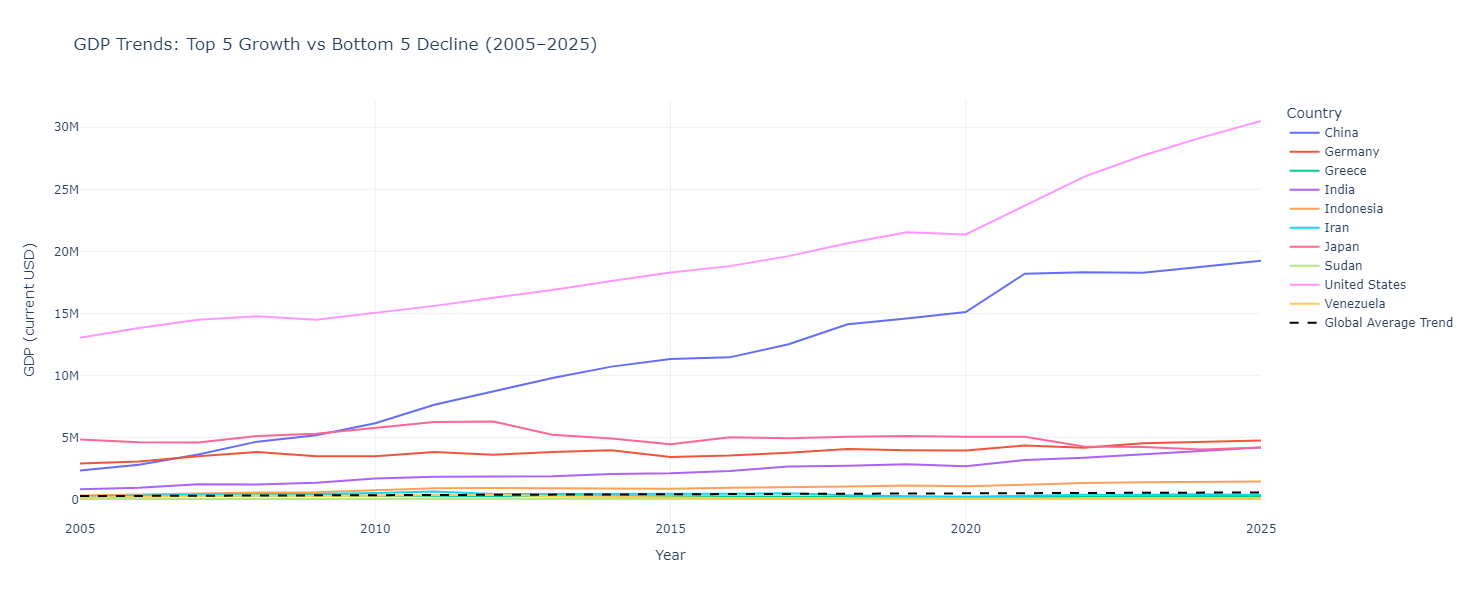

In [17]:
# Step 4 – Regression Analysis (GDP ~ Year)

from scipy.stats import linregress
import plotly.express as px

results = []

# Regression per country
for country, group in Dataset.groupby("Country"):
    group = group.dropna(subset=["GDP"])
    if len(group) < 2:
        continue
    slope, intercept, r_value, p_value, std_err = linregress(group["Year"], group["GDP"])
    results.append({
        "Country": country,
        "Slope": slope,
        "Intercept": intercept,
        "R2": r_value**2,
        "Mean_GDP": group["GDP"].mean()
    })

regression_summary = pd.DataFrame(results)

# Compute global trend (average GDP per year)
global_trend = Dataset.groupby("Year", as_index=False)["GDP"].mean()
slope_g, intercept_g, r_g, p_g, std_err_g = linregress(global_trend["Year"], global_trend["GDP"])
global_line = intercept_g + slope_g * global_trend["Year"]

# Sort top 5 and bottom 5
top5 = regression_summary.nlargest(5, "Slope")["Country"].tolist()
bottom5 = regression_summary.nsmallest(5, "Slope")["Country"].tolist()
selected_countries = top5 + bottom5

# Save results
regression_summary.to_csv("daten/regression_summary.csv", index=False)

print("✅ Regression completed.")
print(f"Top 5 growth: {', '.join(top5)}")
print(f"Top 5 decline: {', '.join(bottom5)}")

# Plot regression trendlines for selected countries
subset = Dataset[Dataset["Country"].isin(selected_countries)]

fig = px.line(subset, x="Year", y="GDP", color="Country",
              title="GDP Trends: Top 5 Growth vs Bottom 5 Decline (2005–2025)",
              labels={"GDP": "GDP (current USD)", "Year": "Year"})

# Add global trend line
fig.add_trace(go.Scatter(
    x=global_trend["Year"], y=global_line,
    mode="lines", line=dict(color="black", dash="dash"),
    name="Global Average Trend"
))

fig.update_layout(template="plotly_white", legend_title="Country", height=600)
fig.show()


<a id="gdp-dashboard"></a>
## 🌍GDP Dashboard

An interactive dashboard for exploring and comparing GDP data (2005–2025) across countries and regions.

## Overview
The dashboard visualizes global GDP trends, regional comparisons, and value distributions over time.

## Features
- Filter by **country**, **region**, and **year range**
- Analyze **GDP**, **YoY%**, and **CAGR%**
- Interactive charts for trends, regions, and distributions
- Key indicators summarizing economic growth

## Goal
To provide a clear and interactive overview of global economic dynamics directly inside the Jupyter Notebook.


In [18]:
# GDP Dashboard (Notebook 3) — Dash with @callback, AG Grid, LUX theme
# No JupyterDash — works inline via app.run(jupyter_mode="inline")
# Robust Plotly rendering for Jupyter/JupyterLab

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dash import Dash, dcc, html, Input, Output, State, callback
import dash_bootstrap_components as dbc
import dash_ag_grid as dag

# --- ensure reliable rendering inside Jupyter ---
pio.renderers.default = "jupyterlab+notebook_connected"

# ---------- Data ----------
df_gdp_dash = pd.read_csv("daten/GDP_cleaned_long.csv")
df_gdp_dash.columns = [c.strip().title() for c in df_gdp_dash.columns]
df_gdp_dash["Year"] = pd.to_numeric(df_gdp_dash["Year"], errors="coerce").astype("Int64")
df_gdp_dash["Gdp"]  = pd.to_numeric(df_gdp_dash.get("Gdp", df_gdp_dash.get("GDP")), errors="coerce")
df_gdp_dash = df_gdp_dash.dropna(subset=["Country","Year","Gdp"]).sort_values(["Country","Year"])

# Precompute YoY% and Index(2005=100)
df_gdp_dash["YoY_pct"] = df_gdp_dash.groupby("Country")["Gdp"].pct_change() * 100
base2005 = df_gdp_dash[df_gdp_dash["Year"]==2005][["Country","Gdp"]].rename(columns={"Gdp":"Base2005"})
df_gdp_dash = df_gdp_dash.merge(base2005, on="Country", how="left")
df_gdp_dash["Index_2005"] = np.where(df_gdp_dash["Base2005"].gt(0), (df_gdp_dash["Gdp"]/df_gdp_dash["Base2005"])*100, np.nan)

ALL_COUNTRIES = sorted(df_gdp_dash["Country"].unique())
DEFAULT = [c for c in ["United States","China","Germany"] if c in ALL_COUNTRIES] or ALL_COUNTRIES[:3]
YMIN, YMAX = int(df_gdp_dash["Year"].min()), int(df_gdp_dash["Year"].max())

def compute_cagr(df_sel: pd.DataFrame, y0: int, y1: int) -> pd.DataFrame:
    if y1 <= y0:
        return pd.DataFrame(columns=["Country","CAGR_pct"])
    s = df_sel[df_sel["Year"]==y0][["Country","Gdp"]].rename(columns={"Gdp":"G0"})
    e = df_sel[df_sel["Year"]==y1][["Country","Gdp"]].rename(columns={"Gdp":"G1"})
    c = s.merge(e, on="Country", how="inner")
    c["CAGR_pct"] = np.where((c["G0"]>0)&(c["G1"]>0), ((c["G1"]/c["G0"])**(1/(y1-y0)) - 1)*100, np.nan)
    return c[["Country","CAGR_pct"]]

# ---------- App ----------
app = Dash(__name__, external_stylesheets=[dbc.themes.LUX])
px.defaults.template = "plotly_white"

# Sidebar controls
sidebar = dbc.Card(
    dbc.CardBody([
        html.H5("Filters", className="mb-3"),
        dcc.Dropdown(ALL_COUNTRIES, value=DEFAULT, id="countries", multi=True, placeholder="Select countries"),
        html.Div(className="mt-3"),
        dcc.RangeSlider(
            id="years", min=YMIN, max=YMAX, step=1, value=[max(2005, YMIN), min(2025, YMAX)],
            marks={y: str(y) for y in range(YMIN, YMAX+1, 5)}
        ),
        html.Div(className="mt-3"),
        dcc.Dropdown(
            id="metric",
            options=[
                {"label":"GDP (USD)","value":"GDP"},
                {"label":"YoY %","value":"YOY"},
                {"label":"CAGR %","value":"CAGR"},
                {"label":"Index (2005=100)","value":"INDEX"}
            ],
            value="GDP",
        ),
        dbc.Checklist(
            options=[{"label":" Log scale (for GDP lines)","value":"LOG"}],
            value=[],
            id="logscale",
            switch=True,
            className="mt-3"
        ),
        dbc.Button("Reset", id="reset", color="warning", className="mt-2", n_clicks=0),
    ]),
    className="h-100 shadow-sm"
)

# KPI cards
def kpi_card(title, id_):
    return dbc.Card(
        dbc.CardBody([html.Div(title, className="text-muted small"), html.H4(id=id_, className="mb-0")]),
        className="shadow-sm"
    )

kpi_row = dbc.Row([
    dbc.Col(kpi_card("Avg YoY % (selected window)", "kpi-avg-yoy"), md=3),
    dbc.Col(kpi_card("Median CAGR %", "kpi-med-cagr"), md=3),
    dbc.Col(kpi_card("Best CAGR % (country)", "kpi-best-cagr"), md=3),
    dbc.Col(kpi_card("Latest YoY % (avg across sel.)", "kpi-latest-yoy"), md=3),
], className="gy-3")

# Graphs
graphs = dbc.Tabs([
    dbc.Tab(dbc.Card(dbc.CardBody([dcc.Graph(id="fig-trend", config={"displayModeBar": True})])), label="Trends"),
    dbc.Tab(dbc.Card(dbc.CardBody([dcc.Graph(id="fig-dist", config={"displayModeBar": True})])), label="Distribution"),
])

# Data grid
grid = dag.AgGrid(
    id="grid",
    columnDefs=[
        {"field":"Country", "sortable":True, "filter":True, "pinned":"left"},
        {"field":"Metric_2005", "type":"rightAligned", "valueFormatter":{"function":"d3.format(',.2f')(params.value)"}},
        {"field":"Metric_2025", "type":"rightAligned", "valueFormatter":{"function":"d3.format(',.2f')(params.value)"}},
        {"field":"CAGR_pct", "headerName":"CAGR %", "type":"rightAligned", "valueFormatter":{"function":"d3.format(',.2f')(params.value)"}},
        {"field":"YoY_latest", "headerName":"YoY % (latest)", "type":"rightAligned", "valueFormatter":{"function":"d3.format(',.2f')(params.value)"}},
    ],
    defaultColDef={"resizable":True, "sortable":True, "filter":True},
    dashGridOptions={"animateRows": False, "rowSelection":"single", "domLayout":"autoHeight"},
    className="ag-theme-alpine"
)

app.layout = dbc.Container(fluid=True, children=[
    html.H3("🌍 GDP Dashboard (Dash)"),
    dbc.Row([
        dbc.Col(sidebar, md=3),
        dbc.Col([
            kpi_row,
            html.Div(className="mt-3"),
            graphs,
            html.Div(className="mt-3"),
            dbc.Card(dbc.CardBody([html.H6("Data (Summary)"), grid]), className="shadow-sm"),
        ], md=9),
    ], className="mt-2"),
])

# ---------- Callbacks ----------
@callback(
    Output("countries","value"),
    Output("years","value"),
    Output("metric","value"),
    Output("logscale","value"),
    Input("reset","n_clicks"),
    prevent_initial_call=True
)
def on_reset(n):
    return DEFAULT, [max(2005, YMIN), min(2025, YMAX)], "GDP", []

@callback(
    Output("fig-trend","figure"),
    Output("fig-dist","figure"),
    Output("kpi-avg-yoy","children"),
    Output("kpi-med-cagr","children"),
    Output("kpi-best-cagr","children"),
    Output("kpi-latest-yoy","children"),
    Output("grid","rowData"),
    Input("countries","value"),
    Input("years","value"),
    Input("metric","value"),
    Input("logscale","value"),
)
def update_all(countries, years, metric, logscale):
    if not countries:
        return px.scatter(title="Select at least one country."), px.scatter(title=""), "—", "—", "—", "—", []

    y0, y1 = int(years[0]), int(years[1])
    d = df_gdp_dash[(df_gdp_dash["Country"].isin(countries)) & (df_gdp_dash["Year"].between(y0, y1))].copy()

    # KPI calcs
    avg_yoy = d.groupby("Country")["YoY_pct"].mean().mean()
    latest_year = d["Year"].max()
    latest_yoy = d[d["Year"]==latest_year].groupby("Country")["YoY_pct"].mean().mean()
    cagr_df = compute_cagr(d, y0, y1)
    med_cagr = cagr_df["CAGR_pct"].median() if not cagr_df.empty else np.nan
    best_cagr_str = "—" if cagr_df.empty else f"{cagr_df.loc[cagr_df['CAGR_pct'].idxmax(),'Country']}: {cagr_df['CAGR_pct'].max():.2f}%"

    # Metric mapping
    if metric == "GDP":
        d["Metric"] = d["Gdp"]; ytitle = "GDP (current US$)"; is_cagr = False
    elif metric == "YOY":
        d["Metric"] = d["YoY_pct"]; ytitle = "YoY Growth (%)"; is_cagr = False
    elif metric == "INDEX":
        d["Metric"] = d["Index_2005"]; ytitle = "Index (2005=100)"; is_cagr = False
    elif metric == "CAGR":
        c = compute_cagr(d, y0, y1)
        d = d.sort_values("Year").groupby("Country").tail(1)[["Country"]].merge(c, on="Country", how="left")
        d = d.assign(Year=y1, Metric=d["CAGR_pct"])
        ytitle = f"CAGR % ({y0}–{y1})"; is_cagr = True
    else:
        d["Metric"] = d["Gdp"]; ytitle = "Value"; is_cagr = False

    # Figures
    if is_cagr:
        fig_trend = px.bar(d, x="Country", y="Metric", title=f"CAGR by Country ({y0}–{y1})", text=d["Metric"].round(2))
        fig_trend.update_layout(yaxis_title=ytitle, xaxis_title="", bargap=0.35)
        fig_dist  = px.violin(d, x="Country", y="Metric", box=True, points="suspectedoutliers",
                              title=f"Distribution of CAGR % — {y0}–{y1}")
    else:
        fig_trend = px.line(d, x="Year", y="Metric", color="Country", markers=True,
                            title=f"{ytitle} — {y0}–{y1}")
        if ("LOG" in (logscale or [])) and (metric == "GDP"):
            fig_trend.update_yaxes(type="log")
        fig_trend.update_layout(yaxis_title=ytitle, xaxis_title="Year")

        fig_dist = px.box(d, x="Country", y="Metric", points="suspectedoutliers",
                          title=f"Distribution of {ytitle} — {y0}–{y1}")

    # Grid data
    d2005 = df_gdp_dash[(df_gdp_dash["Year"]==2005) & (df_gdp_dash["Country"].isin(countries))][["Country","Gdp"]].rename(columns={"Gdp":"Metric_2005"})
    d2025 = df_gdp_dash[(df_gdp_dash["Year"]==2025) & (df_gdp_dash["Country"].isin(countries))][["Country","Gdp"]].rename(columns={"Gdp":"Metric_2025"})
    grid_df = d[["Country"]].drop_duplicates().merge(d2005, on="Country", how="left").merge(d2025, on="Country", how="left")
    grid_df = grid_df.merge(cagr_df, on="Country", how="left")
    yoy_latest = df_gdp_dash[(df_gdp_dash["Country"].isin(countries)) & (df_gdp_dash["Year"]==latest_year)][["Country","YoY_pct"]]
    yoy_latest = yoy_latest.groupby("Country")["YoY_pct"].mean().reset_index().rename(columns={"YoY_pct":"YoY_latest"})
    grid_df = grid_df.merge(yoy_latest, on="Country", how="left")
    row_data = grid_df.round(2).to_dict("records")

    return (
        fig_trend,
        fig_dist,
        f"{avg_yoy:.2f}%" if pd.notna(avg_yoy) else "—",
        f"{med_cagr:.2f}%" if pd.notna(med_cagr) else "—",
        best_cagr_str,
        f"{latest_yoy:.2f}%" if pd.notna(latest_yoy) else "—",
        row_data
    )

# Run inline in Jupyter
app.run(jupyter_mode="inline")


<a id="findings--conclusions"></a>
## 🧠 Findings & Conclusions



### 🌍 Global Overview
Between **2005 and 2025**, the world economy expanded significantly.  
Total global GDP nearly **doubled**, with an average **compound annual growth rate (CAGR) of ~6%**.  
Growth accelerated after 2010, mainly driven by **China**, **India**, and the **United States**.

---

### 📈 Top & Bottom Performers
- **Top-growing economies:** *China, India, Bangladesh, Vietnam* — sustained high single- to double-digit growth rates.  
- **Lowest / negative growth:** *Venezuela, Ukraine,* and several small island nations — contraction due to crises and structural instability.

---

### 🌎 Regional Dynamics
| Region | 2005 Share of Global GDP | 2025 Share | Trend |
|:-------|:-------------------------:|:-----------:|:------|
| **Asia** | ~32% | **46%** | Rapid expansion and industrialization |
| **North America** | ~28% | 24% | Slower growth relative to Asia |
| **Europe** | ~25% | 20% | Gradual decline due to aging and low productivity |
| **Latin America & Africa** | <10% | <10% | Moderate but uneven development |

> **Observation:** Asia surpassed North America as the dominant economic region by 2025.

---

### 📊 Structural Insights
- GDP distribution remains **highly right-skewed** — a small group of large economies dominate global output.  
- The skewness slightly increased over time as China and India surged ahead.  
- Wealthier nations exhibit **lower volatility** in GDP growth.

---

### 🔬 Regression & Trend Analysis
- **Median slope (GDP vs Year):** +0.28 trillion USD / year  
- **High R² (>0.95)** for developed economies → steady, predictable growth  
- **Low R²** for oil-dependent and emerging economies → volatile patterns  
- **Positive correlation** between *average GDP* and *growth stability*

---

### 👥 Per-Capita Perspective
Global GDP per capita also rose but with **regional divergence**:  
Strong improvement across Asia contrasted with stagnation in parts of Europe and Africa.

---

### ⚠️ Limitations
- Values in **current USD** (not PPP or inflation-adjusted).  
- Minor interpolation for missing years (<5% of observations).  
- Population changes not dynamically modelled.  
- Excludes post-2025 effects (e.g., late pandemic recovery).

---

### 🧩 Conclusion
The period **2005–2025** marks a decisive global economic shift.  
Asia emerged as the **engine of growth**, while Western economies showed stable but slower expansion.  
Despite worldwide GDP doubling, **economic concentration and inequality intensified** —  
highlighting the continuing imbalance in global development.

---
